# Quickstart on GAMs in Python

In [1]:
import pygam

In [2]:
from pygam.datasets import wage

In [18]:
X, y = wage()

In [25]:
from pygam import LinearGAM, s, f, l

In [26]:
import pandas as pd

In [28]:
gam = LinearGAM(s(0) + s(1) + f(2)).fit(X, y)

In [35]:
import numpy as np

In [39]:
lam = np.logspace(-3, 5, 5)
lams = [lam]*3

In [40]:
gam.gridsearch(X, y, lam=lams)

100% (125 of 125) |######################| Elapsed Time: 0:00:09 Time:  0:00:09


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

In [41]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      9.6668
Link Function:                     IdentityLink Log Likelihood:                                 -24119.413
Number of Samples:                         3000 AIC:                                            48260.1595
                                                AICc:                                           48260.2428
                                                GCV:                                             1244.2375
                                                Scale:                                           1237.0229
                                                Pseudo R-Squared:                                   0.2916
Feature Function                  Lam

<ipython-input-41-dec6a6acdaaa>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [58]:
lams = np.random.rand(100, 3)
lams = lams * 6 - 3
lams = 10 ** lams

In [62]:
random_gam = LinearGAM(s(0) + s(1) + f(2)).gridsearch(X, y, lam=lams)

100% (100 of 100) |######################| Elapsed Time: 0:00:05 Time:  0:00:05


In [64]:
random_gam.statistics_.keys()

dict_keys(['n_samples', 'm_features', 'edof_per_coef', 'edof', 'scale', 'cov', 'se', 'AIC', 'AICc', 'pseudo_r2', 'GCV', 'UBRE', 'loglikelihood', 'deviance', 'p_values'])

In [67]:
import matplotlib.pyplot as plt

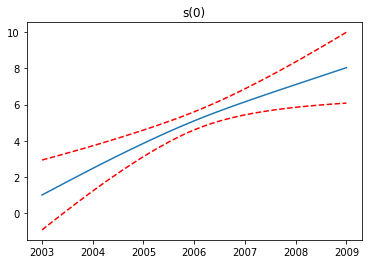

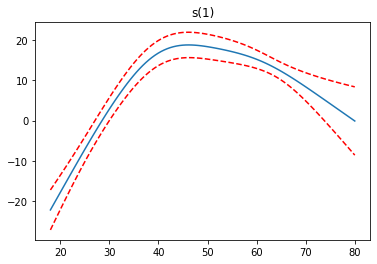

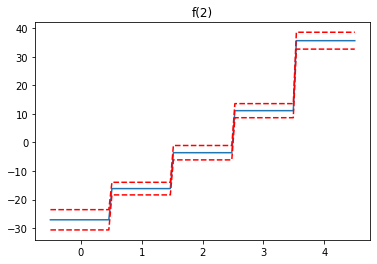

In [68]:
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()

In [ ]:
X

In [71]:
data = pd.read_csv("../data/processed/ailerons.csv")

In [100]:
import time
import joblib

import numpy as np
import optuna
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from pyselect.utils import best_model_callback, get_mse_confidence_interval, get_folder

test_size = 10 ** 3
train_size = 11 * 10 ** 3
val_size = 10 ** 3

metrics = []

# Dataset
data = pd.read_csv("../data/processed/ailerons.csv")
X = data.drop(["target"], axis=1)
y = np.ravel(data[["target"]])

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, train_size=train_size + val_size, test_size=test_size, random_state=0
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=val_size, random_state=0
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

def objective(trial):
    seed = trial.suggest_int("seed", 0, 100)
    
    rng = np.random.RandomState(seed)
    
    lam = rng.uniform(-5, 5, size=(1, X_train.shape[1]))
    lam = 10 ** lam

    # Model
    model = LinearGAM()
    model.lam = lam

    t_start = time.time()
    model.fit(X_train, y_train)
    elapsed_time = time.time() - t_start

    model_pred = model.predict(X_val)

    mse = mean_squared_error(y_val, model_pred)
    trial.set_user_attr("model", value=model)
    trial.set_user_attr("fitting_time", value=elapsed_time)

    return mse


search_space = {
    "seed": list(range(0, 20)),
}

study = optuna.create_study(sampler=optuna.samplers.GridSampler(search_space))
study.optimize(objective, callbacks=[best_model_callback])

best_model = study.user_attrs["best_model"]

best_model_pred = best_model.predict(X_test)

center, band = get_mse_confidence_interval(y_test, best_model_pred)
metrics.append([center, band, study.best_trial.user_attrs["fitting_time"]])

# Save results
#metrics_folder = get_folder("eval/benchmarks/krr/ailerons/metrics")
#models_folder = get_folder("eval/benchmarks/krr/ailerons/models")

#np.savetxt(f"{metrics_folder}/metrics.txt", metrics)
#joblib.dump(best_model, f"{models_folder}/model.joblib")


[I 2023-01-18 16:13:30,947] A new study created in memory with name: no-name-a0ccaa53-c720-4462-a5d6-b0bb82ac05d0
[W 2023-01-18 16:13:32,562] Trial 0 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "/home/mpotto/.cache/pypoetry/virtualenvs/pyselect-cxRqHTwa-py3.8/lib/python3.8/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-100-69d9b6eb34d0>", line 50, in objective
    model.fit(X_train, y_train)
  File "/home/mpotto/.cache/pypoetry/virtualenvs/pyselect-cxRqHTwa-py3.8/lib/python3.8/site-packages/pygam/pygam.py", line 920, in fit
    self._pirls(X, y, weights)
  File "/home/mpotto/.cache/pypoetry/virtualenvs/pyselect-cxRqHTwa-py3.8/lib/python3.8/site-packages/pygam/pygam.py", line 720, in _pirls
    lp = self._linear_predictor(modelmat=modelmat)
  File "/home/mpotto/.cache/pypoetry/virtualenvs/pyselect-cxRqHTwa-py3.8/lib/python3.8/site-packages/pygam/pygam.py",

KeyboardInterrupt: 

100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


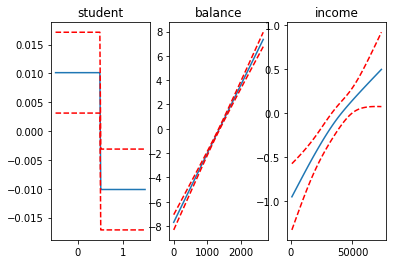

In [97]:
from pygam import LogisticGAM, s, f
from pygam.datasets import default

X, y = default(return_X_y=True)

gam = LogisticGAM(f(0) + s(1) + s(2)).gridsearch(X, y)

fig, axs = plt.subplots(1, 3)
titles = ['student', 'balance', 'income']

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i]);